In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import polyfit, poly1d
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import splrep, splev
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import seaborn as sns
import kw
import kwgraph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dfs = kw.getdf_xlsx()

df_master = dfs['試験マスタ']
df_data = dfs['試験データ']

df =df_master.merge(df_data, on='test_id')

df['theoretical_power'] = df['capacity'] * df['total_head'] * 9.8 / 60
df['pump_eff'] = df['theoretical_power'] / df['shaft_power'] * 100

# データを'model'と'test_no'でグループ化し、それぞれのグループに対してグラフを作成します
models = df['model'].unique()
models

array(['AZ40F2.2', 'AZ40F3.7', 'AZ50F2.2', 'AZ50F3.7', 'AZ65F3.7'],
      dtype=object)

In [3]:
selected_models = [
   ['AZ65F3.7', 'AZ50F3.7', 'AZ40F3.7'],
   ['AZ50F2.2'],
   ['AZ40F2.2'],
]

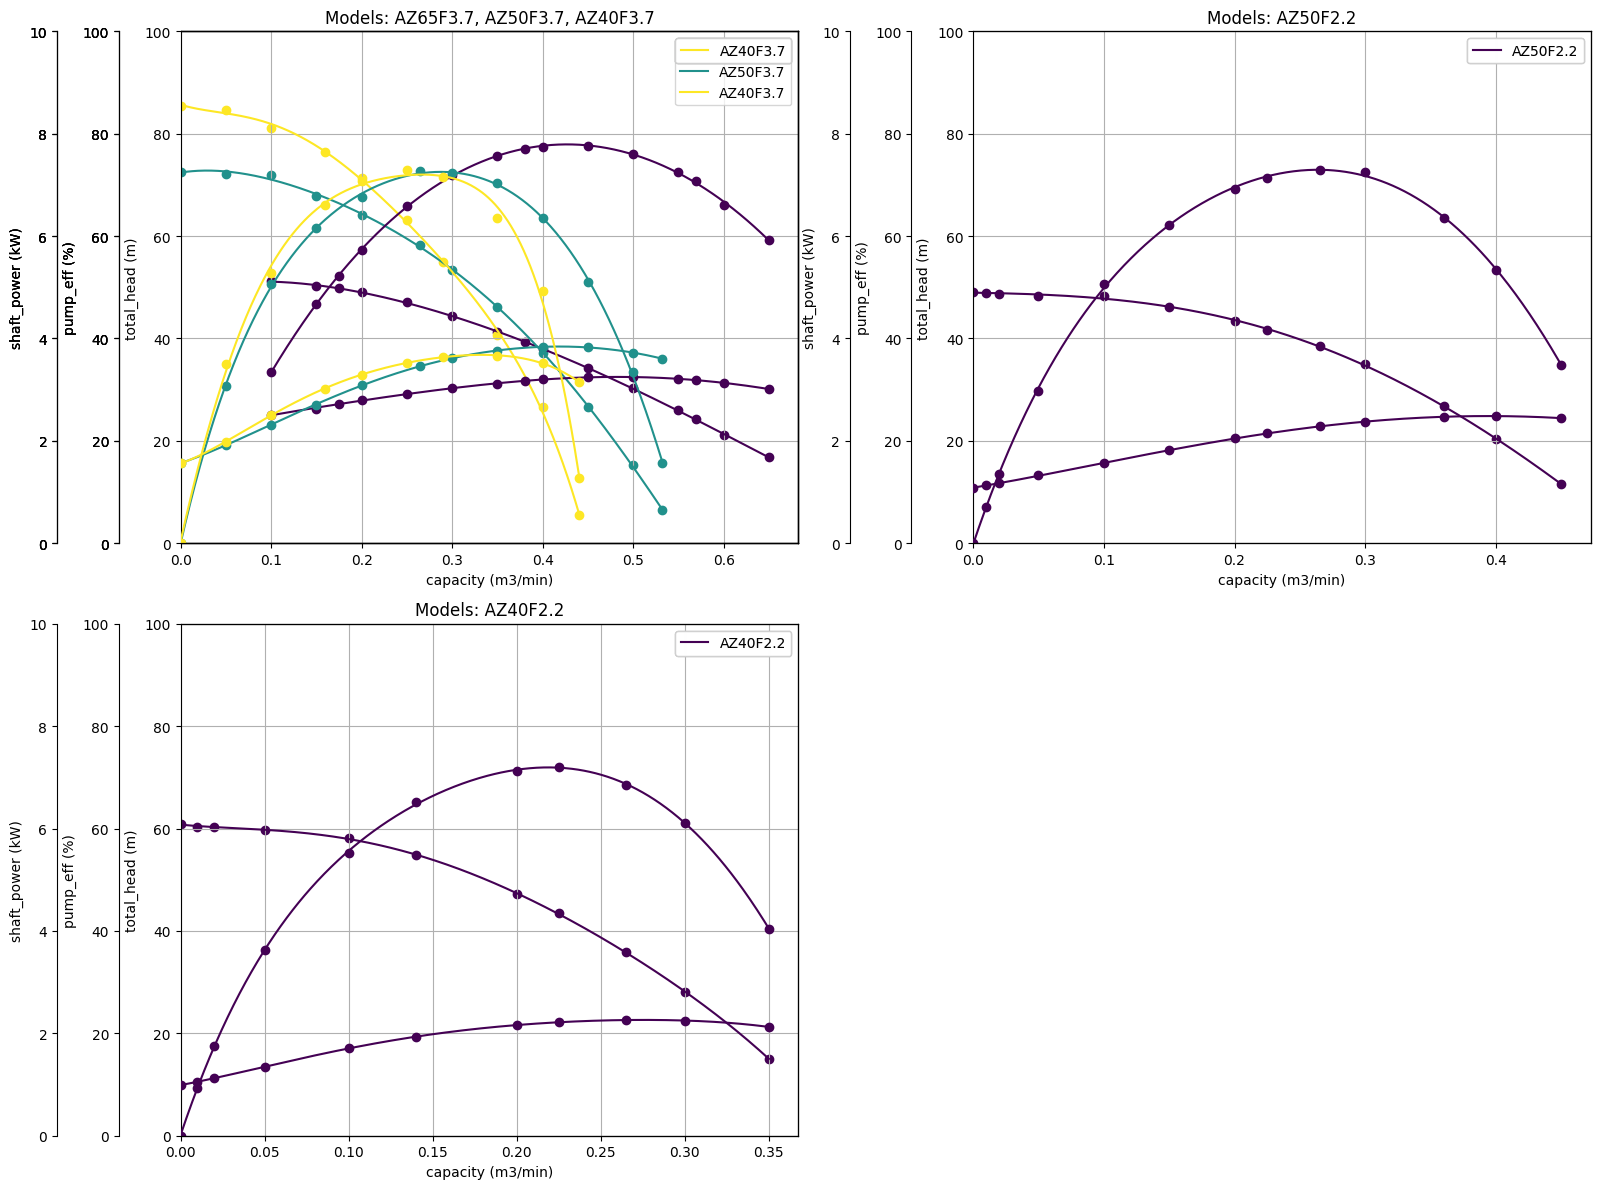

In [11]:
kwgraph.draw_plot4(df, selected_models,
                  y_axis_lims=[(0, 100), (0, 100), (0, 10)],
                  types_of_plot=["scatter", "polyfit"],
                  use_colormap=True,
                  )

ここから下は不要

In [ ]:
# モデル毎の色を指定します
model_colors = ['k', 'r', 'b']

# 軸毎の色を指定します
axis_colors = ['tab:blue', 'tab:orange', 'tab:green']

In [ ]:
# 軸の設定
x_axis = 'capacity'
X_axis_unit = 'm3/min'
xlim_min = 0
xlim_max = None

y_axis1 = 'total_head'
y_axis_unit1 = 'm'

y_axis2 = 'pump_eff'
y_axis_unit2 = '%'

y_axis3 = 'shaft_power'
y_axis_unit3 = 'kW'


## 暫定

In [ ]:
#点と近似曲線を両方描画するようにする

# データを'model'と'test_no'でグループ化し、それぞれのグループに対してグラフを作成します
all_models = df['model'].unique()

selected_models = [
   ['AZ65F3.7', 'AZ50F3.7', 'AZ40F3.7'],
   'AZ50F2.2',
   'AZ40F2.2'
]

# selected_modelsの各要素がリストでなければ、リストに変換します
selected_models = [model if isinstance(model, list) else [model] for model in selected_models]

# モデル毎の色を指定します
model_colors = ['k', 'r', 'b']

# 軸毎の色を指定します
axis_colors = ['tab:blue', 'tab:orange', 'tab:green']  # Noneを設定します

# model_colorsがNoneの場合、axis_colorsで実行
if model_colors is None:
    model_colors = axis_colors

# axis_colorsがNoneまたは両方ある場合、model_colorsで実行
if axis_colors is None or model_colors is not None:
    axis_colors = model_colors

# リストの長さが不足する場合の対策として、リストを複数回繰り返す
model_colors = model_colors * max(sum(len(models) for models in selected_models) // len(model_colors) + 1, 1)
axis_colors = axis_colors * max(3 // len(axis_colors) + 1, 1)

# サブプロットの行数を設定します
num_rows = 2

# モデルの数に基づいてサブプロットの列数を計算します
num_cols = len(selected_models) // num_rows
if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
    num_cols += 1  # 列数を1つ増やします

# Figure and array of axes are created
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axs = axs.ravel()

for i, models in enumerate(selected_models):
    color_index = 0  # ここでcolor_indexをリセット
    for models in models:
        for model in models:
            color = model_colors[color_index]  # model_colors listから色を選択
            color_index += 1

            df_model = df[df['model'] == model]

            # Current axes are selected
            ax1 = axs[i]

            ax1.set_xlabel(f'{x_axis} ({X_axis_unit})')
            ax1.set_ylabel(f'{y_axis1} ({y_axis_unit1})', color=axis_colors[0])
            # (line1,) = ax1.plot(df_model[x_axis], df_model[y_axis1], color=color, label=y_axis1 + " (" + model + ")")  # colorをmodel_colorsから選択
            
            # 近似曲線
            # coeffs1 = np.polyfit(df_model[x_axis], df_model[y_axis1], 6)
            # approx_y_axis1 = np.polyval(coeffs1, df_model[x_axis])
            # (line1,) = ax1.plot(df_model[x_axis], approx_y_axis1, color=color, label=y_axis1 + " (" + model + ")")  
            
            # スプライン近似
            spline1 = UnivariateSpline(df_model[x_axis], df_model[y_axis1])
            approx_y_axis1 = spline1(df_model[x_axis])
            (line1,) = ax1.plot(df_model[x_axis], approx_y_axis1, color=color, label=y_axis1 + " (" + model + ")") 
            
            ax1.tick_params(axis='y', labelcolor=axis_colors[0])
            ax1.set_xlim(0,)
            ax1.set_ylim(0, 100)
            ax1.grid(True)

            # 2つ目のy軸の作成
            ax2 = ax1.twinx()

            ax2.spines['left'].set_position(('axes', -0.1))
            ax2.yaxis.set_label_position('left')
            ax2.yaxis.set_ticks_position('left')

            ax2.set_ylabel(f'{y_axis2} ({y_axis_unit2})', color=axis_colors[1])
            # (line2,) = ax2.plot(df_model[x_axis], df_model[y_axis2], color=color, label=y_axis2 + " (" + model + ")")  # colorをmodel_colorsから選択
            
            # 近似曲線
            # coeffs2 = np.polyfit(df_model[x_axis], df_model[y_axis2], 3)
            # approx_y_axis2 = np.polyval(coeffs2, df_model[x_axis])
            # (line2,) = ax2.plot(df_model[x_axis], approx_y_axis2, color=color, label=y_axis2 + " (" + model + ")")  
            
            # スプライン近似
            spline2 = UnivariateSpline(df_model[x_axis], df_model[y_axis2])
            approx_y_axis2 = spline2(df_model[x_axis])
            (line2,) = ax2.plot(df_model[x_axis], approx_y_axis2, color=color, label=y_axis2 + " (" + model + ")") 
            
            ax2.tick_params(axis='y', labelcolor=axis_colors[1])
            ax2.set_ylim(0, 100)  # total_headの範囲を設定

            # 3つ目のy軸の作成
            ax3 = ax1.twinx()

            ax3.spines['left'].set_position(('axes', -0.2))
            ax3.yaxis.set_label_position('left')
            ax3.yaxis.set_ticks_position('left')

            ax3.set_ylabel(f'{y_axis3} ({y_axis_unit3})', color=axis_colors[2])
            # (line3,) = ax3.plot(df_model[x_axis], df_model[y_axis3], color=color, label=y_axis3 + " (" + model + ")")  # colorをmodel_colorsから選択
            
            # 近似曲線
            coeffs3 = np.polyfit(df_model[x_axis], df_model[y_axis3], 3)
            approx_y_axis3 = np.polyval(coeffs3, df_model[x_axis])
            (line3,) = ax3.plot(df_model[x_axis], approx_y_axis3, color=color, label=y_axis2 + " (" + model + ")")  
            
            ax3.tick_params(axis='y', labelcolor=axis_colors[2])
            ax3.set_ylim(0, 10) 

        # 凡例の作成
        lines = [line1, line2, line3]
        # labels = [l.get_label() for l in lines]
        
        labels = models
        # ax1.legend(lines, labels, loc='best')
        ax1.legend(labels, loc='best')

    ax1.set_title(f'Models: {", ".join(models)}')

# 使用しないサブプロットを削除
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axs[j])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


1.色の修正を反映

In [ ]:
# データを'model'と'test_no'でグループ化し、それぞれのグループに対してグラフを作成します
all_models = df['model'].unique()

selected_models = [
   ['AZ65F3.7', 'AZ50F3.7', 'AZ40F3.7'],
   'AZ50F2.2',
   'AZ40F2.2'
]

# selected_modelsの各要素がリストでなければ、リストに変換します
selected_models = [model if isinstance(model, list) else [model] for model in selected_models]

# モデル毎の色を指定します
model_colors = ['k', 'r', 'b']

# 軸毎の色を指定します
axis_colors = ['tab:blue', 'tab:orange', 'tab:green']

# サブプロットの行数を設定します
num_rows = 2

# モデルの数に基づいてサブプロットの列数を計算します
num_cols = len(selected_models) // num_rows
if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
    num_cols += 1  # 列数を1つ増やします

# Figure and array of axes are created
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axs = axs.ravel()

for i, models in enumerate(selected_models):
    color_index = 0  # ここでcolor_indexをリセット
    for model in models:
        color = model_colors[color_index]  # model_colors listから色を選択
        color_index += 1

        df_model = df[df['model'] == model]

        # Current axes are selected
        ax1 = axs[i]
        ax1.set_xlabel(f'{x_axis} ({X_axis_unit})')
        ax1.set_ylabel(f'{y_axis1} ({y_axis_unit1})', color=axis_colors[0])

        # スプライン近似
        spline1 = UnivariateSpline(df_model[x_axis], df_model[y_axis1])
        approx_y_axis1 = spline1(df_model[x_axis])
        (line1,) = ax1.plot(df_model[x_axis], approx_y_axis1, color=color, label=y_axis1 + " (" + model + ")") 

        ax1.tick_params(axis='y', labelcolor=axis_colors[0])
        ax1.set_xlim(0,)
        ax1.set_ylim(0, 100)
        ax1.grid(True)

        # 2つ目のy軸の作成
        ax2 = ax1.twinx()
        ax2.spines['left'].set_position(('axes', -0.1))
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('left')

        ax2.set_ylabel(f'{y_axis2} ({y_axis_unit2})', color=axis_colors[1])

        # スプライン近似
        spline2 = UnivariateSpline(df_model[x_axis], df_model[y_axis2])
        approx_y_axis2 = spline2(df_model[x_axis])
        (line2,) = ax2.plot(df_model[x_axis], approx_y_axis2, color=color, label=y_axis2 + " (" + model + ")") 

        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylim(0, 100)  

        # 3つ目のy軸の作成
        ax3 = ax1.twinx()
        ax3.spines['left'].set_position(('axes', -0.2))
        ax3.yaxis.set_label_position('left')
        ax3.yaxis.set_ticks_position('left')

        ax3.set_ylabel(f'{y_axis3} ({y_axis_unit3})', color=axis_colors[2])

        # 近似曲線
        coeffs3 = np.polyfit(df_model[x_axis], df_model[y_axis3], 3)
        approx_y_axis3 = np.polyval(coeffs3, df_model[x_axis])
        (line3,) = ax3.plot(df_model[x_axis], approx_y_axis3, color=color, label=y_axis2 + " (" + model + ")")  

        ax3.tick_params(axis='y', labelcolor=axis_colors[2])
        ax3.set_ylim(0, 10) 

    # 凡例の作成
    labels = models
    ax1.legend(labels, loc='best')
    ax1.set_title(f'Models: {", ".join(models)}')

# 使用しないサブプロットを削除
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axs[j])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


2.点の描画

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np

# 軸の設定
x_axis = 'capacity'
X_axis_unit = 'm3/min'

y_axis1 = 'total_head'
y_axis_unit1 = 'm'

y_axis2 = 'pump_eff'
y_axis_unit2 = '%'

y_axis3 = 'shaft_power'
y_axis_unit3 = 'kW'

# データを'model'と'test_no'でグループ化し、それぞれのグループに対してグラフを作成します
all_models = df['model'].unique()

selected_models = [
   ['AZ65F3.7', 'AZ50F3.7', 'AZ40F3.7'],
   'AZ50F2.2',
   'AZ40F2.2'
]

# selected_modelsの各要素がリストでなければ、リストに変換します
selected_models = [model if isinstance(model, list) else [model] for model in selected_models]

# モデル毎の色を指定します
model_colors = ['k', 'r', 'b']

# 軸毎の色を指定します
axis_colors = ['tab:blue', 'tab:orange', 'tab:green']

# サブプロットの行数を設定します
num_rows = 2

# モデルの数に基づいてサブプロットの列数を計算します
num_cols = len(selected_models) // num_rows
if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
    num_cols += 1  # 列数を1つ増やします

# Figure and array of axes are created
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axs = axs.ravel()

for i, models in enumerate(selected_models):
    color_index = 0  # ここでcolor_indexをリセット
    for model in models:
        color = model_colors[color_index]  # model_colors listから色を選択
        color_index += 1

        df_model = df[df['model'] == model]

        # Current axes are selected
        ax1 = axs[i]
        ax1.set_xlabel(f'{x_axis} ({X_axis_unit})')
        ax1.set_ylabel(f'{y_axis1} ({y_axis_unit1})', color=axis_colors[0])

        # データ点のプロット
        ax1.scatter(df_model[x_axis], df_model[y_axis1], color=color, label=y_axis1 + " (" + model + ")") 

        # スプライン近似
        spline1 = UnivariateSpline(df_model[x_axis], df_model[y_axis1])
        approx_y_axis1 = spline1(df_model[x_axis])
        (line1,) = ax1.plot(df_model[x_axis], approx_y_axis1, color=color) 

        ax1.tick_params(axis='y', labelcolor=axis_colors[0])
        ax1.set_xlim(0,)
        ax1.set_ylim(0, 100)
        ax1.grid(True)

        # 2つ目のy軸の作成
        ax2 = ax1.twinx()
        ax2.spines['left'].set_position(('axes', -0.1))
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('left')

        ax2.set_ylabel(f'{y_axis2} ({y_axis_unit2})', color=axis_colors[1])

        # データ点のプロット
        ax2.scatter(df_model[x_axis], df_model[y_axis2], color=color, label=y_axis2 + " (" + model + ")") 

        # スプライン近似
        spline2 = UnivariateSpline(df_model[x_axis], df_model[y_axis2])
        approx_y_axis2 = spline2(df_model[x_axis])
        (line2,) = ax2.plot(df_model[x_axis], approx_y_axis2, color=color) 

        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylim(0, 100)  

        # 3つ目のy軸の作成
        ax3 = ax1.twinx()
        ax3.spines['left'].set_position(('axes', -0.2))
        ax3.yaxis.set_label_position('left')
        ax3.yaxis.set_ticks_position('left')

        ax3.set_ylabel(f'{y_axis3} ({y_axis_unit3})', color=axis_colors[2])

        # データ点のプロット
        ax3.scatter(df_model[x_axis], df_model[y_axis3], color=color, label=y_axis3 + " (" + model + ")") 

        # 近似曲線
        coeffs3 = np.polyfit(df_model[x_axis], df_model[y_axis3], 3)
        approx_y_axis3 = np.polyval(coeffs3, df_model[x_axis])
        (line3,) = ax3.plot(df_model[x_axis], approx_y_axis3, color=color)  

        ax3.tick_params(axis='y', labelcolor=axis_colors[2])
        ax3.set_ylim(0, 10) 

    # 凡例の作成
    labels = models
    ax1.legend(labels, loc='best')
    ax1.set_title(f'Models: {", ".join(models)}')

# 使用しないサブプロットを削除
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axs[j])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

3 最大流量の自動調整

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np

# 軸の設定
x_axis = 'capacity'
X_axis_unit = 'm3/min'

y_axis1 = 'total_head'
y_axis_unit1 = 'm'

y_axis2 = 'pump_eff'
y_axis_unit2 = '%'

y_axis3 = 'shaft_power'
y_axis_unit3 = 'kW'

# 'model'と'test_no'でデータをグループ化し、各グループに対してグラフを作成
all_models = df['model'].unique()

selected_models = [
   ['AZ65F3.7', 'AZ50F3.7', 'AZ40F3.7'],
   'AZ50F2.2',
   'AZ40F2.2'
]

# selected_modelsの各要素がリストでなければ、リストに変換
selected_models = [model if isinstance(model, list) else [model] for model in selected_models]

# モデル毎の色を指定
model_colors = ['k', 'r', 'b']

# 軸毎の色を指定
axis_colors = ['tab:blue', 'tab:orange', 'tab:green']

# サブプロットの行数を設定
num_rows = 2

# モデルの数に基づいてサブプロットの列数を計算
num_cols = len(selected_models) // num_rows
if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
    num_cols += 1  # 列数を1つ増やす

# Figureとarray of axesを作成
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axs = axs.ravel()

for i, models in enumerate(selected_models):
    color_index = 0  # ここでcolor_indexをリセット
    x_max = 0  # x_maxを初期化
    for model in models:
        color = model_colors[color_index]  # model_colors listから色を選択
        color_index += 1

        df_model = df[df['model'] == model]

        # 現在のモデルに対するxの最大値を取得
        x_max_model = df_model[x_axis].max()

        # これが現在のx_maxより大きければ、x_maxを更新
        if x_max_model > x_max:
            x_max = x_max_model

        # 現在のaxesを選択
        ax1 = axs[i]
        ax1.set_xlabel(f'{x_axis} ({X_axis_unit})')
        ax1.set_ylabel(f'{y_axis1} ({y_axis_unit1})', color=axis_colors[0])

        # データ点のプロット
        ax1.scatter(df_model[x_axis], df_model[y_axis1], color=color)

        # スプライン近似
        spline1 = UnivariateSpline(df_model[x_axis], df_model[y_axis1])
        approx_y_axis1 = spline1(df_model[x_axis])
        ax1.plot(df_model[x_axis], approx_y_axis1, color=color, label=model)

        ax1.tick_params(axis='y', labelcolor=axis_colors[0])
        ax1.set_ylim(0, 100)
        ax1.grid(True)

        # 2つ目のy軸の作成
        ax2 = ax1.twinx()
        ax2.spines['left'].set_position(('axes', -0.1))
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('left')

        ax2.set_ylabel(f'{y_axis2} ({y_axis_unit2})', color=axis_colors[1])

        # データ点のプロット
        ax2.scatter(df_model[x_axis], df_model[y_axis2], color=color)

        # スプライン近似
        spline2 = UnivariateSpline(df_model[x_axis], df_model[y_axis2])
        approx_y_axis2 = spline2(df_model[x_axis])
        ax2.plot(df_model[x_axis], approx_y_axis2, color=color, label=model)

        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylim(0, 100)

        # 3つ目のy軸の作成
        ax3 = ax1.twinx()
        ax3.spines['left'].set_position(('axes', -0.2))
        ax3.yaxis.set_label_position('left')
        ax3.yaxis.set_ticks_position('left')

        ax3.set_ylabel(f'{y_axis3} ({y_axis_unit3})', color=axis_colors[2])

        # データ点のプロット
        ax3.scatter(df_model[x_axis], df_model[y_axis3], color=color)

        # 近似曲線
        coeffs3 = np.polyfit(df_model[x_axis], df_model[y_axis3], 3)
        approx_y_axis3 = np.polyval(coeffs3, df_model[x_axis])
        ax3.plot(df_model[x_axis], approx_y_axis3, color=color, label=model)

        ax3.tick_params(axis='y', labelcolor=axis_colors[2])
        ax3.set_ylim(0, 10)

    # すべてのモデルについてループが終わった後に、このサブプロットのxlimを設定
    ax1.set_xlim(0, x_max)

    # 凡例の作成
    ax1.legend(loc='best')
    ax1.set_title(f'Models: {", ".join(models)}')

# 使用しないサブプロットを削除
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()

更に滑らかなスプライン補完

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import numpy as np

# 以下は既存のコード

# モデルの数に基づいてサブプロットの列数を計算
num_cols = len(selected_models) // num_rows
if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
    num_cols += 1  # 列数を1つ増やす

# Figureとarray of axesを作成
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axs = axs.ravel()

for i, models in enumerate(selected_models):
    color_index = 0  # ここでcolor_indexをリセット
    x_max = 0  # x_maxを初期化
    for model in models:
        color = model_colors[color_index]  # model_colors listから色を選択
        color_index += 1

        df_model = df[df['model'] == model]

        # 現在のモデルに対するxの最大値を取得
        x_max_model = df_model[x_axis].max()

        # これが現在のx_maxより大きければ、x_maxを更新
        if x_max_model > x_max:
            x_max = x_max_model

        # 現在のaxesを選択
        ax1 = axs[i]
        ax1.set_xlabel(f'{x_axis} ({X_axis_unit})')
        ax1.set_ylabel(f'{y_axis1} ({y_axis_unit1})', color=axis_colors[0])

        # データ点のプロット
        ax1.scatter(df_model[x_axis], df_model[y_axis1], color=color) 

        # Cubic Spline補間
        sorted_df = df_model.sort_values(by=x_axis)  # xに基づいてデータをソート
        spline1 = CubicSpline(sorted_df[x_axis], sorted_df[y_axis1])
        xs = np.linspace(df_model[x_axis].min(), df_model[x_axis].max(), 500)
        ax1.plot(xs, spline1(xs), color=color, label=model)

        ax1.tick_params(axis='y', labelcolor=axis_colors[0])
        ax1.set_ylim(0, 100)
        ax1.grid(True)

        # 以下、2つ目と3つ目のy軸についても同様に変更を行います。

        ax2 = ax1.twinx()
        ax2.spines['left'].set_position(('axes', -0.1))
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('left')
        ax2.set_ylabel(f'{y_axis2} ({y_axis_unit2})', color=axis_colors[1])
        ax2.scatter(df_model[x_axis], df_model[y_axis2], color=color) 
        sorted_df = df_model.sort_values(by=x_axis)  # xに基づいてデータをソート
        spline2 = CubicSpline(sorted_df[x_axis], sorted_df[y_axis2])
        ax2.plot(xs, spline2(xs), color=color, label=model)
        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylim(0, 100)  

        ax3 = ax1.twinx()
        ax3.spines['left'].set_position(('axes', -0.2))
        ax3.yaxis.set_label_position('left')
        ax3.yaxis.set_ticks_position('left')
        ax3.set_ylabel(f'{y_axis3} ({y_axis_unit3})', color=axis_colors[2])
        ax3.scatter(df_model[x_axis], df_model[y_axis3], color=color)
        sorted_df = df_model.sort_values(by=x_axis)  # xに基づいてデータをソート
        spline3 = CubicSpline(sorted_df[x_axis], sorted_df[y_axis3])
        ax3.plot(xs, spline3(xs), color=color, label=model)
        ax3.tick_params(axis='y', labelcolor=axis_colors[2])
        ax3.set_ylim(0, 10)

    # すべてのモデルについてループが終わった後に、このサブプロットのxlimを設定
    ax1.set_xlim(0, x_max)

    # 凡例の作成
    ax1.legend(loc='best')
    ax1.set_title(f'Models: {", ".join(models)}')

# 使用しないサブプロットを削除
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axs[j])

fig.tight_layout()  
plt.show()


多項式補完

In [ ]:
import matplotlib.pyplot as plt
from numpy import polyfit, poly1d
import numpy as np

# 以下は既存のコード

# モデルの数に基づいてサブプロットの列数を計算
num_cols = len(selected_models) // num_rows
if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
    num_cols += 1  # 列数を1つ増やす

# Figureとarray of axesを作成
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axs = axs.ravel()

for i, models in enumerate(selected_models):
    color_index = 0  # ここでcolor_indexをリセット
    x_max = 0  # x_maxを初期化
    for model in models:
        color = model_colors[color_index]  # model_colors listから色を選択
        color_index += 1

        df_model = df[df['model'] == model]

        # 現在のモデルに対するxの最大値を取得
        x_max_model = df_model[x_axis].max()

        # これが現在のx_maxより大きければ、x_maxを更新
        if x_max_model > x_max:
            x_max = x_max_model

        # 現在のaxesを選択
        ax1 = axs[i]
        ax1.set_xlabel(f'{x_axis} ({X_axis_unit})')
        ax1.set_ylabel(f'{y_axis1} ({y_axis_unit1})', color=axis_colors[0])

        # データ点のプロット
        ax1.scatter(df_model[x_axis], df_model[y_axis1], color=color) 

        # Polyfit
        poly_coeffs1 = polyfit(df_model[x_axis], df_model[y_axis1], deg=5)
        poly1 = poly1d(poly_coeffs1)
        xs = np.linspace(df_model[x_axis].min(), df_model[x_axis].max(), 500)
        ax1.plot(xs, poly1(xs), color=color, label=model)

        ax1.tick_params(axis='y', labelcolor=axis_colors[0])
        ax1.set_ylim(0, 100)
        ax1.grid(True)

        # 以下、2つ目と3つ目のy軸についても同様に変更を行います。

        ax2 = ax1.twinx()
        ax2.spines['left'].set_position(('axes', -0.1))
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('left')
        ax2.set_ylabel(f'{y_axis2} ({y_axis_unit2})', color=axis_colors[1])
        ax2.scatter(df_model[x_axis], df_model[y_axis2], color=color) 

        poly_coeffs2 = polyfit(df_model[x_axis], df_model[y_axis2], deg=5)
        poly2 = poly1d(poly_coeffs2)
        ax2.plot(xs, poly2(xs), color=color, label=model)

        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylim(0, 100)  

        ax3 = ax1.twinx()
        ax3.spines['left'].set_position(('axes', -0.2))
        ax3.yaxis.set_label_position('left')
        ax3.yaxis.set_ticks_position('left')
        ax3.set_ylabel(f'{y_axis3} ({y_axis_unit3})', color=axis_colors[2])
        ax3.scatter(df_model[x_axis], df_model[y_axis3], color=color)

        poly_coeffs3 = polyfit(df_model[x_axis], df_model[y_axis3], deg=5)
        poly3 = poly1d(poly_coeffs3)
        ax3.plot(xs, poly3(xs), color=color, label=model)

        ax3.tick_params(axis='y', labelcolor=axis_colors[2])
        ax3.set_ylim(0, 10)

    # すべてのモデルについてループが終わった後に、このサブプロットのxlimを設定
    ax1.set_xlim(0, x_max + x_max * 0.05)

    # 凡例の作成
    ax1.legend(loc='best')
    ax1.set_title(f'Models: {", ".join(models)}')

# 使用しないサブプロットを削除
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axs[j])

fig.tight_layout()  
plt.show()

関数化

In [ ]:
import matplotlib.pyplot as plt
from numpy import polyfit, poly1d
import numpy as np

def draw_plot(df, selected_models, x_axis, X_axis_unit, y_axes, y_axis_units, y_axis_lims, types_of_plot, polyfit_degree=3, num_rows=1):
    # モデルの数に基づいてサブプロットの列数を計算
    num_cols = len(selected_models) // num_rows
    if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
        num_cols += 1  # 列数を1つ増やす

    # Figureとarray of axesを作成
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
    axs = axs.ravel()

    for i, models in enumerate(selected_models):
        color_index = 0  # ここでcolor_indexをリセット
        x_max = 0  # x_maxを初期化
        for model in models:
            color = model_colors[color_index]  # model_colors listから色を選択
            color_index += 1

            df_model = df[df['model'] == model]

            # 現在のモデルに対するxの最大値を取得
            x_max_model = df_model[x_axis].max()

            # これが現在のx_maxより大きければ、x_maxを更新
            if x_max_model > x_max:
                x_max = x_max_model

            # 現在のaxesを選択
            ax = axs[i]
            ax.set_xlabel(f'{x_axis} ({X_axis_unit})')
            ax.grid(True)

            # 複数のy軸をプロット
            for j, y_axis in enumerate(y_axes):
                y_axis_unit = y_axis_units[j]
                y_axis_lim = y_axis_lims[j]

                if j > 0:  # 2つ目以降のy軸の場合、新しいAxesを作成
                    ax = ax.twinx()

                    # Y軸の位置を調整
                    ax.spines['left'].set_position(('axes', -0.1 * j))  # 軸の位置を調整
                    ax.yaxis.set_label_position('left')  # ラベルの位置を調整
                    ax.yaxis.set_ticks_position('left')  # ティックの位置を調整

                ax.set_ylabel(f'{y_axis} ({y_axis_unit})', color=axis_colors[j])
                ax.set_ylim(y_axis_lim)

                # データ点のプロット
                if "scatter" in types_of_plot:
                    ax.scatter(df_model[x_axis], df_model[y_axis], color=color)

                # Polyfit
                if "polyfit" in types_of_plot:
                    poly_coeffs = polyfit(df_model[x_axis], df_model[y_axis], deg=polyfit_degree)
                    poly = poly1d(poly_coeffs)
                    xs = np.linspace(df_model[x_axis].min(), df_model[x_axis].max(), 500)
                    ax.plot(xs, poly(xs), color=color, label=model)

                # スプライン補間
                if "spline" in types_of_plot:
                    tck = splrep(df_model[x_axis], df_model[y_axis], k=3)
                    xs = np.linspace(df_model[x_axis].min(), df_model[x_axis].max(), 500)
                    ys = splev(xs, tck)
                    ax.plot(xs, ys, color=color, label=model)

                ax.tick_params(axis='y', labelcolor=axis_colors[j])
                ax.legend(loc='best')

            ax.set_title(f'Models: {", ".join(models)}')

        # すべてのモデルについてループが終わった後に、このサブプロットのxlimを設定
        ax.set_xlim(0, x_max + x_max * 0.05)

    # 使用しないサブプロットを削除
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axs[j])

    fig.tight_layout()  
    plt.show()

# 使い方の例
draw_plot(df, selected_models, 'capacity', 'm3/min', 
          ['total_head', 'pump_eff', 'shaft_power'], 
          ['C', 'hPa', 'te'], [(0, 100), (0, 100), (0, 10)], ['scatter', 'polyfit'], polyfit_degree=6, num_rows=2)


In [ ]:
kwgraph.draw_plot(df, selected_models, 'capacity', 'm3/min', 
          ['total_head', 'pump_eff', 'shaft_power'], 
          ['C', 'hPa', 'te'], [(0, 100), (0, 100), (0, 10)], ['scatter', "spline"], polyfit_degree=6, num_rows=2)

In [ ]:
df_model[x_axis]

## 関数